# Reaction flux fit

In [1]:
import alloregfit as arf
import pandas as pd
import cobra
import numpy as np

Load data and model:

In [2]:
data_dir = "//imsbnas.ethz.ch/Sauer1/users/Xavier/5_Karl_nonbiased/"
results = pd.read_pickle(data_dir+"results_all.pickle")
#met_sd = pd.read_excel(data_dir+"metabolites.xlsx",sheetname=1,index_col="name")
gold = pd.read_csv(data_dir+"gold_standard.csv",index_col="reaction")

cond = ['glc-NCM3722_1','glc-NQ1243_3','glc-NQ1243_4','glc-NQ1243_5','glu-NCM3722_9','glu-NQ393_11','glu-NQ393_12','glu-NQ393_13','glu-NQ393_14']
data_dir = '//imsbnas.ethz.ch/Sauer1/users/Xavier/3_Karl_data/'
model = cobra.io.load_matlab_model(data_dir+"iJO1366.mat")
fluxes = pd.read_excel(data_dir+"fluxes_C13.xlsx",index_col="name")[cond]
metabolites = pd.read_excel(data_dir+"merged_metabolites.xlsx",index_col="name")[cond]
metabolites_sd = pd.read_excel(data_dir+"merged_metabolites_sd.xlsx",index_col="name")[cond]
proteins = pd.read_excel(data_dir+"proteome.xlsx",index_col="name")[cond]
mapping = pd.read_table(data_dir+"ECOLI_83333_idmapping.dat",header=None)
rxn_id = open(data_dir+'reactions.txt').read().splitlines()
reg_coli = pd.read_csv(data_dir+"SMRN.csv",index_col="rxn_id")
summary = arf.define_reactions(rxn_id,model,fluxes,proteins,metabolites,metab_sd=metabolites_sd)

Reduce results to the best validates candidates.

In [3]:
prior = pd.DataFrame(columns=results.columns)
for rxn in list(results['rxn_id'].drop_duplicates()):
    rxn_results = results.loc[results['rxn_id']==rxn]
    rxn_reg = [s[0][4:-2] if s!='' else s for s in list(rxn_results['regulator'])]
    modes = [s if s=='' else '+' if s[0][0:3]=='ACT' else '-' for s in list(rxn_results['regulator'])]
    if rxn.lower() in list(reg_coli.index.values):
        cand = reg_coli.loc[rxn.lower()].drop_duplicates()
        for i,reg in enumerate(cand['metab']):
            if (reg in rxn_reg):
                bools1 = np.array([reg==s for s in rxn_reg])
                bools2 = np.array([cand['mode'].iloc[i]==s for s in modes])
                prior = prior.append(rxn_results.loc[(bools1&bools2),:])
        else:
            bools = [''==s for s in rxn_reg]
            prior = prior.append(rxn_results.loc[bools,:])
prior = prior.sort_values(by='best_lik')
prior.reset_index(drop=True,inplace=True)
prior

,best_fit,best_lik,equation,idx,lik_cond,meas_flux,pred_flux,reaction,regulator,rxn_id,uncertainty
0,K_adp_c K_pep_c K_eq K_atp_c ...,-24.933741,c_amp_c*(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF...,10,"[[-2.66249688237, -2.89091149054, -2.673044230...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.5769493178, 18.7388787608, 11.0854020971,...",adp_c + h_c + pep_c --> atp_c + pyr_c,[ACT:amp_c],PYK,"[60426.5008463, 158660.554367, 25337.1825557, ..."
1,K_adp_c K_pep_c K_eq K_at...,-24.933179,c_fdp_c*(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF...,10,"[[-2.66244792265, -2.8906807382, -2.6729251463...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.5760103969, 18.7372273603, 11.0874072561,...",adp_c + h_c + pep_c --> atp_c + pyr_c,[ACT:fdp_c],PYK,"[3.14924378139e-15, 5.17820978157e-14, 1.13727..."
2,K_adp_c K_pep_c K_eq K_...,-24.932846,c_g6p_c*(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF...,10,"[[-2.66240974659, -2.89059354759, -2.672886109...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.5761145789, 18.7366632347, 11.0875140173,...",adp_c + h_c + pep_c --> atp_c + pyr_c,[ACT:g6p_c],PYK,"[7.47030215426e-08, 2.73667466574e-07, 5.72420..."
3,K_adp_c K_pep_c K_eq K_...,-23.608639,c_pep_c*(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF...,10,"[[-2.46132647093, -2.80365678063, -2.477035781...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.5759037586, 18.7371571719, 11.0875011807,...",adp_c + h_c + pep_c --> atp_c + pyr_c,[ACT:pep_c],PYK,"[1.15195051992e-21, 1.17894546911e-20, 4.28952..."
4,K_adp_c K_pep_c K_eq K_...,-23.608151,(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF)*(c_adp...,10,"[[-2.46127107116, -2.80360611781, -2.476983084...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.5759824856, 18.736966887, 11.0875163855, ...",adp_c + h_c + pep_c --> atp_c + pyr_c,,PYK,"[2.03707300737e-14, 9.08693933058e-14, 5.59040..."
5,K_adp_c K_pep_c K_eq K_atp_c ...,-22.998286,(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF)*(c_adp...,10,"[[-2.47283256299, -2.45677309476, -2.691196360...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[19.1312869108, 15.5871989676, 8.79984398912,...",adp_c + h_c + pep_c --> atp_c + pyr_c,[INH:gtp_c],PYK,"[14477.4388981, 26474.7524766, 22813.3498526, ..."
6,K_adp_c K_pep_c K_eq K_atp...,-19.506642,(K_cat_pykA*c_pykA + K_cat_pykF*c_pykF)*(c_adp...,10,"[[-2.06547714383, -2.06368810259, -2.304697529...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[17.6097143892, 15.2391023388, 9.8321200465, ...",adp_c + h_c + pep_c --> atp_c + pyr_c,[INH:succoa_c],PYK,"[264.067099256, 1118.79740487, 733.341405749, ..."
7,K_g6p_c K_eq K_f6p_c K_6pgc_c K...,-18.715378,K_cat_pgi*c_pgi*(c_g6p_c**1.0 - c_f6p_c**1.0/K...,7,"[[-2.16041877132, -1.8588154571, -1.8901663059...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[7.80307952866, 8.56968980087, 7.68821691841,...",g6p_c <=> f6p_c,[INH:6pgc_c],PGI,"[0.760114921925, 95.4362711329, 124.682744715,..."
8,K_dhap_c K_cat_tpiA 76 24597.3650...,-18.677871,K_cat_tpiA*c_dhap_c**1.0*c_tpiA/(K_dhap_c*(1 +...,13,"[[-2.2033187465, -1.74235816024, -2.0930593405...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[8.78553681482, 10.081801452, 5.84893323075, ...",dhap_c <=> g3p_c,,TPI,"[2.22086407959, 9.54208937054, 0.701178407181,..."
9,K_g6p_c K_eq K_f6p_c K_pep_c ...,-18.655451,K_cat_pgi*c_pgi*(c_g6p_c**1.0 - c_f6p_c**1.0/K...,7,"[[-2.10999997572, -1.85131008268, -1.919498169...",glc-NCM3722_1 glc-NQ1243_3 glc-NQ1243_4...,"[[7.96451978443, 8.33204538753, 7.97498500449,...",g6p_c <=> f6p_c,[INH:pep_c],PGI,"[11.1790385311, 3.97494571314, 0.22488104542, ..."


Plot results:

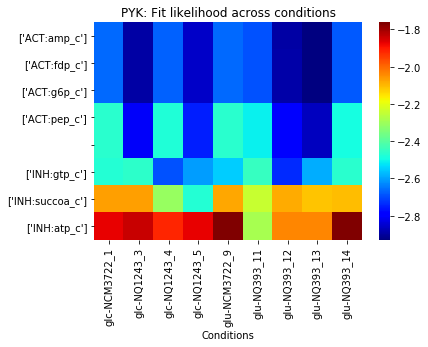

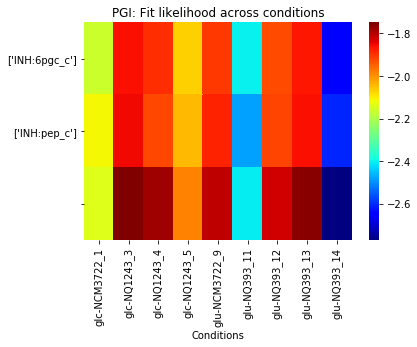

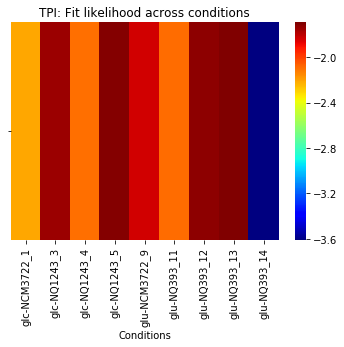

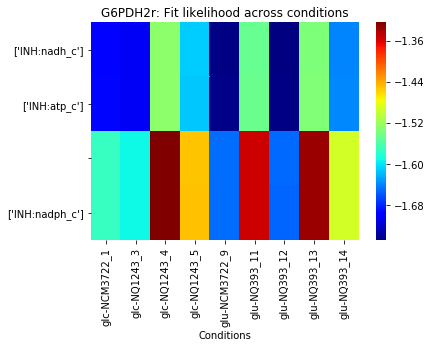

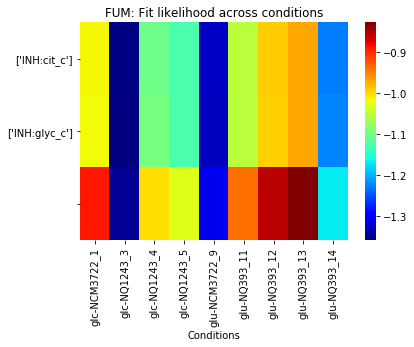

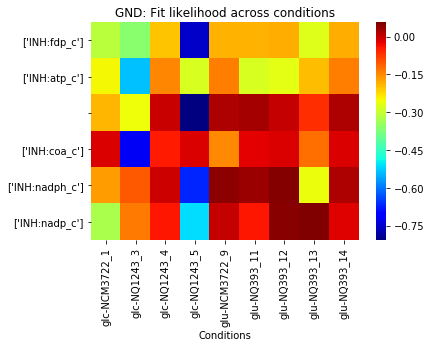

In [4]:
for rxn in list(prior['rxn_id'].drop_duplicates()):
    arf.heatmap_across_conditions(prior,rxn)

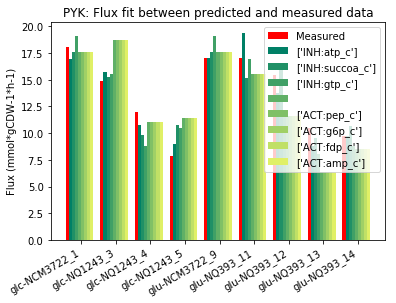

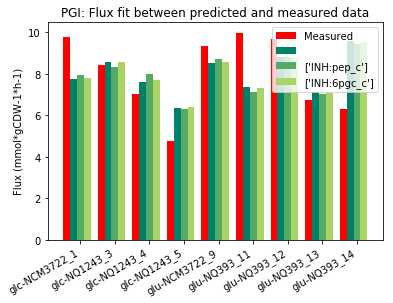

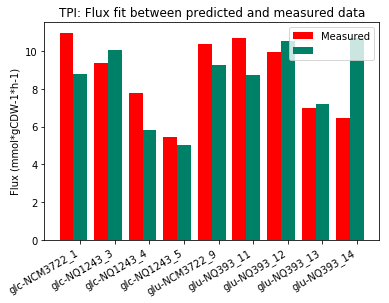

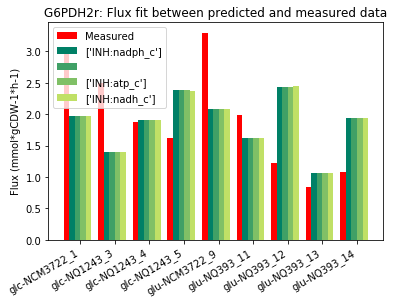

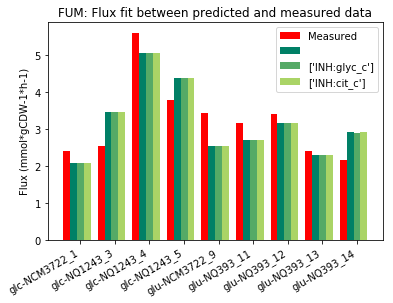

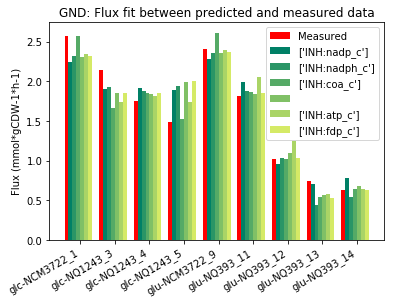

In [5]:
for rxn in list(prior['rxn_id'].drop_duplicates()):
    arf.plot_fit(rxn,prior)

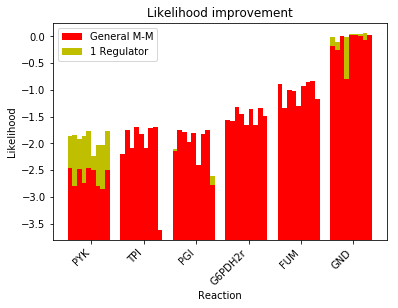

In [6]:
arf.plot_likelihood(prior)